In [1]:
import os
import time
import csv
import signal
import itertools
import random
import numpy as np
from tqdm import tqdm

from concurrent.futures import ProcessPoolExecutor, TimeoutError
from rasengan.problems.facility_location_problem import generate_flp
from rasengan.problems.k_partition_problem import generate_kpp
from rasengan.problems.job_scheduling_problem import generate_jsp
from rasengan.problems.set_cover_problem import generate_scp
from rasengan.problems.graph_coloring_problem import generate_gcp
from rasengan.solvers.optimizers import CobylaOptimizer
from rasengan.solvers.qiskit import (
    HeaSolver, PenaltySolver, ChocoSolver, RasenganSolver,
    AerGpuProvider, AerProvider, DdsimProvider, FakeQuebecProvider,
)
from rasengan.utils.qiskit_plugin import detect_device

device = detect_device()
print(f"Backend device: {device}")

Backend device: GPU


In [2]:
num_cases = 2
problem_scale = 4

flp_problems_pkg, flp_configs_pkg = generate_flp(num_cases, [(1, 2), (2, 3), (3, 3), (3, 4)][:problem_scale], 10, 30)
kpp_problems_pkg, kpp_configs_pkg = generate_kpp(num_cases, [(4, 2, 3), (5, 3, 4), (6, 3, 5), (7, 3, 6)][:problem_scale], 1, 20)
jsp_problems_pkg, jsp_configs_pkg = generate_jsp(num_cases, [(2, 2, 3), (2, 3, 4), (3, 3, 5), (3, 4, 6)][:problem_scale], 1, 20)
scp_problems_pkg, scp_configs_pkg = generate_scp(num_cases, [(4, 4), (5, 5), (6, 6), (7, 7)][:problem_scale])
gcp_problems_pkg, gcp_configs_pkg = generate_gcp(num_cases, [(3, 1), (3, 2), (4, 1), (4, 2)][:problem_scale])

In [3]:
latency_path = "latency.csv"

problems_pkg = flp_problems_pkg + kpp_problems_pkg + jsp_problems_pkg + scp_problems_pkg + gcp_problems_pkg

metrics_lst = ['depth', 'num_params','latency_all']
solvers = [HeaSolver, PenaltySolver, ChocoSolver, RasenganSolver]
headers = ["pkid", 'method', 'layers'] + metrics_lst

def process_layer(prb, num_layers, solver, metrics_lst):
    opt = CobylaOptimizer(max_iter=300)
    provider = FakeQuebecProvider()
    used_solver = solver(
        prb_model = prb,
        optimizer = opt,
        provider = provider,
        num_layers = num_layers,
        shots = 1024*10,
    )
    metrics = used_solver.circuit_analyze(metrics_lst)
    return metrics

if __name__ == '__main__':
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 # Set timeout duration
    num_complete = 0
    
    with open(f'{latency_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count() // 2
    with ProcessPoolExecutor(max_workers=num_processes_cpu) as executor:
        futures = []
        id = 0
        for solver in solvers:
            for pkid, problems in enumerate(problems_pkg):
                for problem in problems:
                    # print(f'process_{id} build')
                    id += 1
                    num_layers = 5
                    future = executor.submit(process_layer, problem, num_layers, solver, metrics_lst)
                    futures.append((future, pkid, solver.__name__, num_layers))

        start_time = time.perf_counter()
        for future, pkid, solver, num_layers in tqdm(futures, desc="Evaluating latency"):
            current_time = time.perf_counter()
            remaining_time = max(set_timeout - (current_time - start_time), 0)
            diff = []
            try:
                result = future.result(timeout=remaining_time)
                diff.extend(result)
                # print(f"Task for problem {pkid}, num_layers {num_layers} executed successfully.")
            except MemoryError:
                diff.append('memory_error')
                print(f"Task for problem {pkid}, num_layers {num_layers} encountered a MemoryError.")
            except TimeoutError:
                diff.append('timeout')
                print(f"Task for problem {pkid}, num_layers {num_layers} timed out.")
            finally:
                row = [pkid, solver, num_layers] + diff
                with open(f'{latency_path}', mode='a', newline='') as file:
                    writer = csv.writer(file)
                    writer.writerow(row)  # Write row immediately
                num_complete += 1
                if num_complete == len(futures):
                    # print(f'Data has been written to {latency_path}')
                    for process in executor._processes.values():
                        os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {latency_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Evaluating latency: 100%|██████████| 160/160 [05:15<00:00,  1.97s/it]


Data has been written to latency.csv
Time elapsed: 318.53s


In [4]:
evaluate_csv_path = 'evaluate.csv'

problems_pkg = list(
    itertools.chain(
        enumerate(flp_problems_pkg),
        enumerate(kpp_problems_pkg),
        enumerate(jsp_problems_pkg),
        enumerate(scp_problems_pkg),
        enumerate(gcp_problems_pkg),
    )
)

solvers = [HeaSolver, PenaltySolver, ChocoSolver, RasenganSolver]
evaluation_metrics = ['best_solution_probs', 'in_constraints_probs', 'ARG', 'iteration_count', 'classcial', 'quantum', 'run_times']
headers = ['pkid', 'pbid', 'layers', "variables", 'constraints', 'method'] + evaluation_metrics

def process_layer(prb, num_layers, solver):
    opt = CobylaOptimizer(max_iter=200)
    ddsim = DdsimProvider(transpile_mode=0)
    cpu = AerProvider()
    gpu = AerGpuProvider()
    baseline_provider = cpu if device == 'CPU' else gpu

    prb.set_penalty_lambda(400)
    used_solver = solver(
        prb_model = prb,
        optimizer = opt,
        provider = baseline_provider if solver in [HeaSolver, PenaltySolver] else ddsim,
        num_layers = num_layers,
        shots = 1024,
    )
    used_solver.solve()
    eval = used_solver.evaluation()
    time = list(used_solver.time_analyze())
    run_times = used_solver.run_counts()
    return eval + time + [run_times]


if __name__ == '__main__':
    print("Evaluating ARG:")
    all_start_time = time.perf_counter()
    set_timeout = 60 * 60 * 24 * 3 # Set timeout duration
    num_complete = 0
    # print(evaluate_csv_path)
    with open(f'{evaluate_csv_path}', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write headers once

    num_processes_cpu = os.cpu_count()
    # pkid-pbid: 问题包序-包内序号
    
    for pkid, (diff_level, problems) in enumerate(problems_pkg):
        for solver in solvers:
            # 防止GPU内存溢出
            if device == 'GPU' and solver in [HeaSolver, PenaltySolver]:
                num_processes = 2**(4 - diff_level)
            else:
                num_processes = num_processes_cpu // 4

            solver_name = solver.__name__
            with ProcessPoolExecutor(max_workers=num_processes) as executor:
                futures = []
                layer = 5

                for pbid, prb in enumerate(problems):
                    # print(f'{pkid}-{pbid}, {layer}, {solver} build')
                    future = executor.submit(process_layer, prb, layer, solver)
                    futures.append((future, prb, pkid, pbid, layer, solver_name))

                start_time = time.perf_counter()
                for future, prb, pkid, pbid, layer, solver in tqdm(futures, desc=f"problem_{pkid} using {solver_name}"):
                    current_time = time.perf_counter()
                    remaining_time = max(set_timeout - (current_time - start_time), 0)
                    diff = []
                    try:
                        metrics = future.result(timeout=remaining_time)
                        diff.extend(metrics)
                        # print(f"Task for problem {pkid}-{pbid} L={layer} {solver} executed successfully.")
                    except MemoryError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {solver} encountered a MemoryError.")
                        for dict_term in evaluation_metrics:
                            diff.append('memory_error')
                    except TimeoutError:
                        print(f"Task for problem {pkid}-{pbid} L={layer} {solver} timed out.")
                        for dict_term in evaluation_metrics:
                            diff.append('timeout')
                    except Exception as e:
                        print(f"An error occurred: {e}")
                    finally:
                        row = [pkid, pbid, layer, len(prb.variables), len(prb.lin_constr_mtx), solver] + diff
                        with open(f'{evaluate_csv_path}', mode='a', newline='') as file:
                            writer = csv.writer(file)
                            writer.writerow(row)  # Write row immediately
                        num_complete += 1
                        if num_complete == len(futures):
                            # print(f'problem_pkg_{pkid} has finished')
                            for process in executor._processes.values():
                                os.kill(process.pid, signal.SIGTERM)
    print(f'Data has been written to {evaluate_csv_path}')
    print(f"Time elapsed: {time.perf_counter() - all_start_time:.2f}s")

Evaluating ARG:


problem_19 using RasenganSolver: 100%|██████████| 2/2 [00:17<00:00,  8.91s/it]

Data has been written to evaluate.csv
Time elapsed: 21387.92s


In [5]:
import pandas as pd

df = pd.read_csv('evaluate.csv')

df = df.drop(columns=['pbid'])
df = df[df['ARG'] <= 100000]
df['pkid_group'] = df['pkid'] % 4

df_quantum = pd.read_csv('latency.csv')
df_quantum = df_quantum.groupby(['pkid', 'method'], as_index=False).agg({
    'latency_all': 'mean',
})
df_quantum['quantum'] = (df_quantum['latency_all'] * 300 * 1024) / 1e9

df = pd.merge(df, df_quantum[['pkid', 'method', 'quantum']], on=['pkid', 'method'], how='left', suffixes=('', '_new'))
df['quantum'] = df['quantum_new']
df.drop(columns=['quantum_new'], inplace=True)

mean_values = df.groupby('method').mean().reset_index()
mean_values['pkid_group'] = 5
df = pd.concat([df, mean_values], axis=0)

grouped_df = df.groupby(['pkid_group', 'method'], as_index=False).agg({
    'iteration_count': 'mean',
    'classcial': 'mean',
    'quantum': 'mean',
    'run_times': 'mean',
    "ARG": 'mean',
    'in_constraints_probs': 'mean',
    'best_solution_probs': 'mean',
})

values = ['classcial', 'quantum', 'ARG', 'best_solution_probs', 'run_times', 'iteration_count']
method_order = ['HeaSolver', 'PenaltySolver', 'ChocoSolver', 'RasenganSolver']
pivot_df = grouped_df.pivot(index='pkid_group', columns='method', values=values)
pivot_df = pivot_df.reindex(columns=pd.MultiIndex.from_product([values, method_order]))

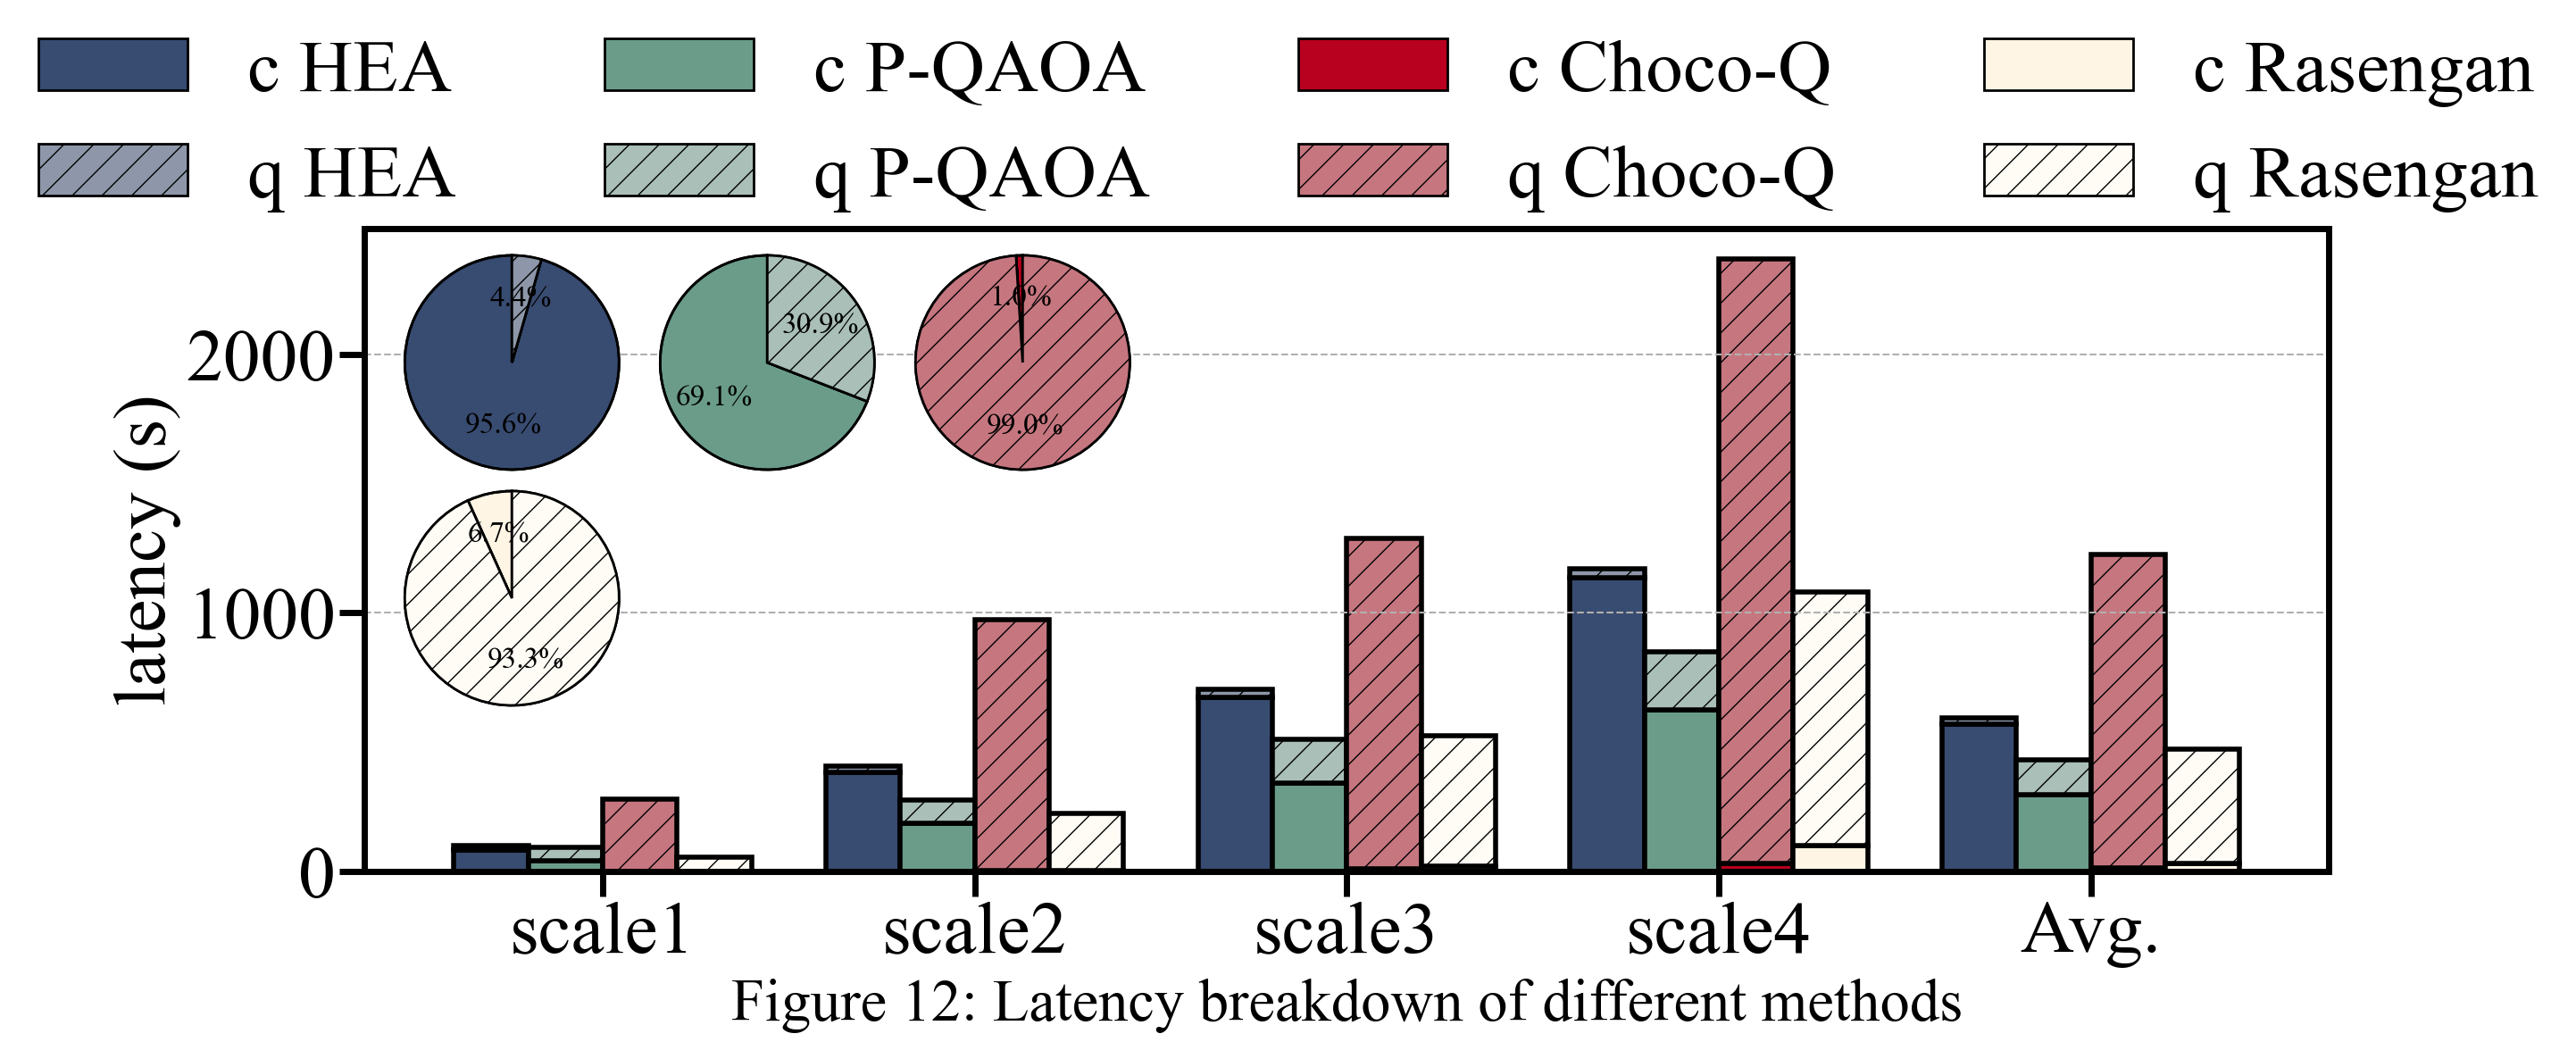

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'font.family': 'Times New Roman',
    'font.size': 60,
    'axes.unicode_minus': False,
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic',
    'mathtext.bf': 'Times New Roman:bold',
    'axes.linewidth': 5,
    'xtick.major.size': 20,
    'xtick.major.width': 5,
    'xtick.minor.size': 10,
    'xtick.minor.width': 3,
    'ytick.major.size': 20,
    'ytick.major.width': 5,
    'ytick.minor.size': 10,
    'ytick.minor.width': 3,
    "lines.markersize": 35,
    "lines.markeredgewidth": 4,
    "markers.fillstyle": 'full',
    'lines.markerfacecolor': '#f8d941',
    'lines.markeredgecolor': 'black',
})

pie_scale = 0.25  # 控制饼图大小（相对于主图）
colors = ['#384B70', '#6A9C89', '#B8001F', '#FFF5E4']
colors_2 = ['#8d97a9', '#a9bfb7', '#c6767f', '#fffcf5']
hatches = ['/', '/', '/', '/']  # 对应四种方法的量子部分斜线

classcial_quantum_sums = {}
for method in method_order:
    data = grouped_df[(grouped_df.method == method) & (grouped_df.pkid_group != 5)]
    classcial_quantum_sums[method] = [data['classcial'].sum(), data['quantum'].sum()]

fig = plt.figure(figsize=(22, 12))
ax = fig.add_axes((0, 0, 1, 0.6))  # 主坐标轴
bar_width = 0.2

for idx, method in enumerate(method_order):
    data = grouped_df[grouped_df.method == method]
    x = np.arange(len(data.pkid_group))
    y_classcial = data['classcial'].to_list()
    y_quantum = data['quantum'].to_list()
    offset = idx * bar_width - (len(method_order) / 2 - 0.5) * bar_width

    ax.bar(x + offset, y_classcial, width=bar_width, color=colors[idx], edgecolor="black", linewidth=4)
    ax.bar(x + offset, y_quantum, width=bar_width, bottom=y_classcial, color=colors_2[idx], edgecolor="black",
           linewidth=4, hatch=hatches[idx])

ax.grid(True, linestyle='--', linewidth=1.5, axis='y')
ax.set_ylabel('latency (s)')
ax.set_xticks(range(5))
ax.set_xticklabels([f"scale{i + 1}" for i in range(4)] + ["Avg."])

pie_positions = [
    (-0.05, 0.35, pie_scale, pie_scale),
    (0.08, 0.35, pie_scale, pie_scale),
    (0.21, 0.35, pie_scale, pie_scale),
    (-0.05, 0.13, pie_scale, pie_scale),
]
for i, (method, values) in enumerate(classcial_quantum_sums.items()):
    sub_ax = fig.add_axes(pie_positions[i])
    sub_ax.pie(values,
               colors=[colors[i], "black"],
               autopct='%1.1f%%', startangle=90,
               wedgeprops={'edgecolor': 'black', 'linewidth': 2},
               textprops={'fontsize': 24})

    wedges, _ = sub_ax.pie(values,
                            colors=["none", colors_2[i]],
                            startangle=90,
                            radius=1,
                            wedgeprops=dict(width=1, edgecolor='black', linewidth=2))
    wedges[1].set_hatch(hatches[i])

labels=["HEA", "P-QAOA", "Choco-Q", "Rasengan"]


handles = []
for i in range(4):
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=colors[i], edgecolor="black", linewidth=2, label=f'c {labels[i]}'))
    handles.append(plt.Rectangle((0, 0), 1, 1, facecolor=colors_2[i], edgecolor="black", linewidth=2, hatch=hatches[i], label=f'q {labels[i]}'))


ax.legend(handles=handles, loc='upper left', ncol=4,
                    bbox_to_anchor=(- 0.2, 1.2, 1, 0.2), frameon=False)

title = "Figure 12: Latency breakdown of different methods"
plt.suptitle(title, y=-0.1, fontsize=48)
plt.savefig(f'{title}.svg', bbox_inches='tight')
plt.show()